This Jupyter Notebook demonstrates how to create a Forest Carbon Diligence subscription with the Subscriptions API, deliver the data to a cloud bucket, and then retrieve and analyze the data directly from the cloud.

## Requirements and environment set up

To execute the code in this example, you will need the following:

- A Planet API key
- Access to the forest_carbon_diligence_30m data layer and associated data resources:
    - CANOPY_HEIGHT_30m
    - CANOPY_COVER_30m
    - ABOVEGROUND_CARBON_DENSITY_30m
- Configured credentials for storage of the results to cloud storage (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite)

The code examples in this workflow are written for Python 3.8 or greater.  
In addition the the Python standard library, the following packages are required:

- keyring
- rasterio
- requests
- rioxarray

First, you will need to import necessary libraries and set up your authentication. For authentication, we will use keyring, which is a package that stores and retrieves credentials like your 
Planet API key. You will be prompted to enter the key once and the API Key will be securely stored on your system keyring.

In [1]:
# Import requirements
import base64
import keyring
import rasterio
import requests
import rioxarray as rx
import xarray as xr
import os
import pandas as pd 
from io import StringIO

# Authentication
update = False # Set to True if you want to update the credentials in the system's keyring

if keyring.get_password("planet", "PL_API_KEY") is None or update:
	keyring.set_password("planet", "PL_API_KEY", "Your API Key")
else:
	print("Using stored api key")

PL_API_KEY = keyring.get_password("planet", "PL_API_KEY")

Using stored api key


Confirm your API key by making a call to Planet services. You should receive back an HTTP 200 response in below.

In [3]:
# Planet's Subscriptions API base URL for making RESTful requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

auth = requests.auth.HTTPBasicAuth(PL_API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
print(response)

<Response [200]>


## Creating a Planetary Variables subscription with the Subscriptions API
To create a subscription, provide a JSON request object that details the subscription parameters, including:

- Subscription name (required)
- Planetary Variable source type (required)
- Data product ID (required)
- Subscription location in GeoJSON format (required)
- Start date for the subscription (required)
- End date for the subscription (optional)

Refer to Products page for details about available parameters.

### Create your JSON Subscription Description Object
This example creates a subscription for ten years of 30 m canopy height data over Shasta National Forest in California.

Depending on your account type, you may have different permissions for different products. For Subscriptions API, you must have access to a particular area of access (AOA). Your area of interest (AOI) must be within your area of access.

Subscriptions can be created with or without a delivery parameter, which specifies a storage location to deliver raster data.  
Omitting the delivery parameter will create a Time Series Delivery subscription. 
This example creates a subscription with a delivery parameter to deliver results directly to a Google Cloud storage bucket.

Refer to the Google Cloud documentation to create a service account key. Use the appropriate credentials for AWS, Azure, or Oracle Cloud Storage platforms.

### Ensure that a delivery destination has been set up 
The Subscriptions API supports delivery to cloud storage providers like Amazon S3, 
Microsoft Azure Blob Storage, Google Cloud Storage, or Oracle Cloud Storage. 
For any cloud storage delivery option, create a cloud storage account with both write and delete access. 
The Subscriptions API supports delivery to a Sentinel Hub collection as well. 

In [3]:
# Read Google application credentials key into memory
GOOGLE_APPLICATION_CREDENTIALS = "key.json"

if not os.path.exists(GOOGLE_APPLICATION_CREDENTIALS):
	credentials_path = os.path.abspath(GOOGLE_APPLICATION_CREDENTIALS)
	print(f"No Google service account key found at: {credentials_path}")

# Subscriptions API expects credentials in base64 format
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
	gcs_credentials_base64 = base64.b64encode(f.read()).decode() 

# Define the bucket name in your Google Cloud Storage
your_bucket_name = "your storage bucket name"

# Create a new subscription JSON payload
payload = {
	"name": "CANOPY_HEIGHT_v1.2.0_30 - Shasta NF",
	"source": {
		"type": "forest_carbon_diligence_30m",
		"parameters": {
	"id": "CANOPY_HEIGHT_v1.2.0_30",
	"start_time": "2013-01-01T00:00:00Z",
	"end_time": "2023-01-01T00:00:00Z",
	"geometry": {
	"type": "Polygon",
	"coordinates": [[
        [-123.39412734481135, 40.53806314480528],
        [-123.39412734481135, 40.53399674816484],
        [-123.38833323662753, 40.53399674816484],
        [-123.38833323662753, 40.53806314480528],
        [-123.39412734481135, 40.53806314480528]
    ]]
    }
    }
    },
    "delivery": {
	    "type": "google_cloud_storage",
	    "parameters": {
		    "bucket": f"{your_bucket_name}",
		    "credentials": gcs_credentials_base64
        }
    }
}

### Create a subscription Using Your JSON Description Object
These details are sent to the Subscriptions API to create a new subscription and receive it's unique subscription ID.

In [4]:
def create_subscription(subscription_payload, auth):
    headers = {
		"content-type": "application/json"}
    try:
        response = requests.post(BASE_URL, json=payload, auth=auth, headers=headers)
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        print(f"Request failed with {response.text}")
    else:
        response_json = response.json()
        subscription_id = response_json["id"]
        print(f"Successfully created new subscription with ID={subscription_id}")
        return subscription_id

### Create a new subscription
subscription_id = create_subscription(payload, auth)
print(subscription_id)

Successfully created new subscription with ID=20def9e1-332c-493e-92fc-f0adc3c1a715
20def9e1-332c-493e-92fc-f0adc3c1a715


### Confirm the Subscription Status
To retrieve the status of the subscription, request the subscription endpoint with a GET request.  Once it is in a 'running' or 'completed' state, the delivery should either be in progress or completed, respectively.  
A subscription with an end date in the future remains in 'running' state until the 'end_date' is in the past.  
See status descriptions for a complete overview of possible status descriptions.

In [7]:
def get_subscription_status(subscription_id, auth):
	subscription_url = f"{BASE_URL}/{subscription_id}"
	response = requests.get(subscription_url, auth=auth)
	response_json = response.json()
	return response_json.get("status")

status = get_subscription_status(subscription_id, auth)
print(status)

running


## Retrieving and analyzing the subscription data
Metadata results generated for this subscription can be retrieved directly in CSV format.

### Retrieve results data in CSV format

In [8]:
# Retrieve the resulting data in CSV format.
resultsCSV = requests.get(f"{BASE_URL}/{subscription_id}/results?format=csv", auth=auth)

# Read CSV Data
df = pd.read_csv(StringIO(resultsCSV.text), parse_dates=["item_datetime", "local_solar_time"])

# Filter by valid data only
df = df[df["ch.band-1.valid_percent"].notnull()]
df = df[df["ch.band-1.valid_percent"] > 0]
df = df[df["status"] != 'QUEUED']

df.head() 

id             item_datetime   status  \
0  88146ce9-92e6-49fc-956b-18d1ff9d36dd 2013-01-01 00:00:00+00:00  SUCCESS   
1  7017a920-b15b-4a03-b8ff-e3ca70f7974a 2014-01-01 00:00:00+00:00  SUCCESS   
2  ac5f21dc-5336-4fd6-8cb6-934185535bf8 2015-01-01 00:00:00+00:00  SUCCESS   
3  6a342b05-6de8-4953-9e7d-312628e2cf8e 2016-01-01 00:00:00+00:00  SUCCESS   
4  8bee50d6-bd7c-4690-b19a-eb35019ef31c 2017-01-01 00:00:00+00:00  SUCCESS   

                       created                      updated errors  \
0    2025-01-16T02:27:47.4475Z  2025-01-16T02:38:37.294478Z     {}   
1  2025-01-16T02:27:50.592236Z      2025-01-16T02:38:37.31Z     {}   
2  2025-01-16T02:27:53.017634Z  2025-01-16T02:38:37.055979Z     {}   
3  2025-01-16T02:27:55.686629Z   2025-01-16T02:38:37.21137Z     {}   
4  2025-01-16T02:27:58.623924Z  2025-01-16T02:38:37.233128Z     {}   

   ch.band-1.mean  ch.band-1.valid_percent  \
0           14.56                      100   
1           14.55                      100   
2           14.54                      100   
3           14.50                      100   
4           14.48                      100   

                                   item_id local_solar_time  \
0  CANOPY_HEIGHT_v1.2.0_30_2013-01-01T0000              NaT   
1  CANOPY_HEIGHT_v1.2.0_30_2014-01-01T0000              NaT   
2  CANOPY_HEIGHT_v1.2.0_30_2015-01-01T0000              NaT   
3  CANOPY_HEIGHT_v1.2.0_30_2016-01-01T0000              NaT   
4  CANOPY_HEIGHT_v1.2.0_30_2017-01-01T0000              NaT   

                 source_id  
0  CANOPY_HEIGHT_v1.2.0_30  
1  CANOPY_HEIGHT_v1.2.0_30  
2  CANOPY_HEIGHT_v1.2.0_30  
3  CANOPY_HEIGHT_v1.2.0_30  
4  CANOPY_HEIGHT_v1.2.0_30

### Retrieving the GeoTIFF
The rioxarray to rasterio can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

There are many options for configuring access through the different cloud storage services. Rasterio uses GDAL under the hood and the configuration options for network based file systems, such as the following:

- Amazon Web Services
- Google Cloud
- Microsoft Azure

The following example reads data directly from the Google Cloud Storage bucket configured previously. To work with canopy cover instead of height, modify the file_location variable to point to canopy cover files. 


In [13]:
year = 2016
# Set the filepath of the GeoTIFF asset
file_location = f"gs://{your_bucket_name}/{subscription_id}/{year}/01/01/CANOPY_HEIGHT_v1.2.0_30-{year}0101T000000Z_ch.tiff"

# Use Google application credentials to allow access to the storage location
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
	data = rx.open_rasterio(file_location)

### Plot the GeoTIFF

You can visualize the resulting raster with below line. 

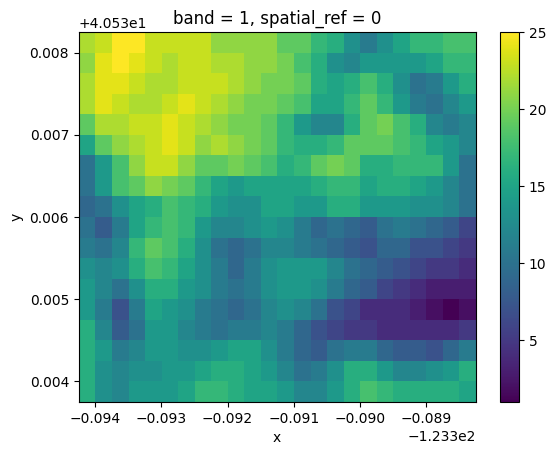

In [14]:
data[0,:,:].plot.imshow() 

### Visualizing Multiple Years of Data

To visualize a time series, load in the annual rasters and concatenate along the time dimension.

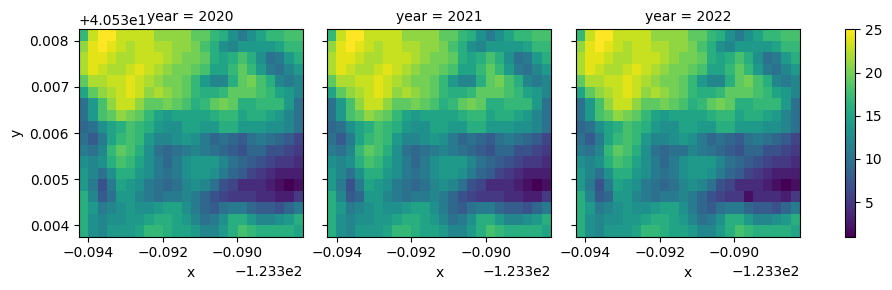

In [16]:
years = [2020, 2021, 2022]

year_data = []

with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):  
  for year in years:        
    f = f"gs://{your_bucket_name}/{subscription_id}/{year}/01/01/CANOPY_HEIGHT_v1.2.0_30-{year}0101T000000Z_ch.tiff"       
    year_data.append(rx.open_rasterio(f, mask_and_scale=True).assign_coords({"year": year}))

timeseries = xr.concat(year_data, dim="year")
timeseries[:,0,:,:].plot.imshow(col="year") 

To visualize the linear trend over time for each pixel, you can use xarrays's polyfit() method.

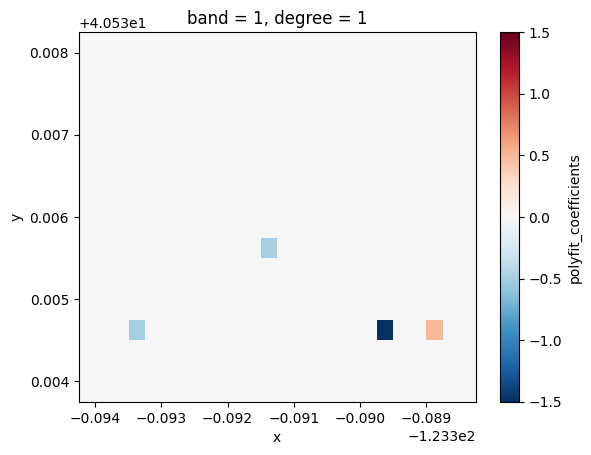

In [17]:
fit = timeseries.polyfit(dim="year", deg=1)
slopes = fit["polyfit_coefficients"].sel(degree=1)
slopes[0,:,:].plot.imshow() 

### Estimating Total Carbon for an Area of Interest (AOI)

You need to place another subscription with "ABOVEGROUND_CARBON_DENSITY" before running the script below.

In [18]:
# Create a new subscription JSON payload
payload = {
	"name": "ABOVEGROUND_CARBON_DENSITY_v1.2.0_30 - Shasta NF",
	"source": {
		"type": "forest_carbon_diligence_30m",
		"parameters": {
	"id": "ABOVEGROUND_CARBON_DENSITY_v1.2.0_30",
	"start_time": "2013-01-01T00:00:00Z",
	"end_time": "2023-01-01T00:00:00Z",
	"geometry": {
	"type": "Polygon",
	"coordinates": [[
        [-123.39412734481135, 40.53806314480528],
        [-123.39412734481135, 40.53399674816484],
        [-123.38833323662753, 40.53399674816484],
        [-123.38833323662753, 40.53806314480528],
        [-123.39412734481135, 40.53806314480528]
    ]]
    }
    }
    },
    "delivery": {
	    "type": "google_cloud_storage",
	    "parameters": {
		    "bucket": f"{your_bucket_name}",
		    "credentials": gcs_credentials_base64
        }
    }
}

### Create a new subscription
subscription_id = create_subscription(payload, auth)
print(subscription_id)

Successfully created new subscription with ID=61e89989-6519-4e5f-8ae3-be7f9d5da10f
61e89989-6519-4e5f-8ae3-be7f9d5da10f


To estimate total carbon for an AOI, read the carbon data, select data from your AOI, and sum over pixels. 

In [7]:
year = 2016
# read carbon data
c_location = f"gs://{your_bucket_name}/{subscription_id}/{year}/01/01/ABOVEGROUND_CARBON_DENSITY_v1.2.0_30-{year}0101T000000Z_acd.tiff" 

with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
	carbon = rx.open_rasterio(c_location)

# define a geometry for the area of interest
xmin = -123.39
xmax = -123.38
ymin = 40.535
ymax = 40.536

aoi = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [xmin, ymin],
            [xmin, ymax],
            [xmax, ymax],
            [xmax, ymin],
            [xmin, ymin]
        ]]
    }
]

# clip carbon data to the AOI
aoi_carbon = carbon.rio.clip(aoi)

# compute total carbon
total_carbon = (aoi_carbon.sum() * 0.09).values

print(f"{total_carbon:.2f} Mg (tons) of carbon")

133.83 Mg (tons) of carbon
